In [88]:
# Prelude
import ralphlib
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


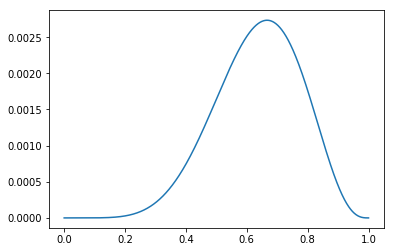

In [89]:
# 3E1
def world_toss_likelihood(num_water, num_tries):
    return lambda grid: stats.binom.pmf(num_water, num_tries, grid)

grid = np.linspace(start=0, stop=1, num=1000)
posterior = pd.Series(
    data=ralphlib.grid_approx(
        ralphlib.uniform_prior,
        world_toss_likelihood(6, 9),
        grid
    ),
    index=grid
)
posterior.plot()

In [90]:
posterior[posterior.index >= 0.2].sum()

0.9991439048705782

(array([   74.,   656.,  2709.,  7669., 14620., 21276., 24144., 18780.,
         8834.,  1238.]),
 array([0.1031031 , 0.19179179, 0.28048048, 0.36916917, 0.45785786,
        0.54654655, 0.63523524, 0.72392392, 0.81261261, 0.9013013 ,
        0.98998999]),
 <a list of 10 Patch objects>)

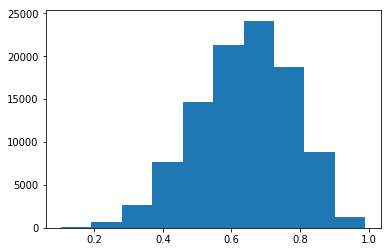

In [91]:
sample_size = 100000
sample = ralphlib.sample(posterior, sample_size)
plt.hist(sample)

In [92]:
param_values, counts = np.unique(sample, return_counts=True)
sample_freq = pd.Series(
    index=param_values,
    data=counts / sample_size
)

In [93]:
# 3E1
# Note: we are working with frequencies here! 
sample_freq[sample_freq.index < 0.2].sum()

0.0009200000000000001

In [94]:
# 3E2
sample_freq[sample_freq.index > 0.8].sum()

0.12075999999999999

In [95]:
# 3E3
sample_freq[(sample_freq.index > 0.2) & (sample_freq.index < 0.8)].sum()

0.87832

In [96]:
# 2E4
# Note: we are working directly with samples here!
# It's not easy (or possible? I think you need actual occurrence numbers and 
# not just frequency/probability?) to compute quantiles over frequencies/
# probabilities.
quantile0_2 = np.quantile(sample, 0.2)
quantile0_2

0.5165165165165165

In [97]:
sample_freq[sample_freq.index <= quantile0_2].sum()

0.20108000000000004

In [98]:
# 2E5
quantile0_8 = np.quantile(sample, 0.8)
quantile0_8

0.7607607607607607

In [99]:
sample_freq[sample_freq.index > quantile0_8].sum()

0.19899

In [100]:
# 3E6
def hdpi(sample, density):
    """Compute the highest density interval of the given density
    using the given samples from a distribution."""
    param_values, counts = np.unique(sample, return_counts=True)
    distribution = pd.Series(
        index=param_values,
        data=counts / len(sample)
    )
    
    distr_cumsum = distribution.cumsum()
    cumsum_density = distr_cumsum + density
    cumsum_density = cumsum_density[cumsum_density <= 1.0]
    # TODO do we need to finagle the np.quantile call to ensure it
    # only returns parameter values in the grid?
    q_series = cumsum_density.apply(lambda q: np.quantile(sample, q))
    
    fin_series = pd.Series(
        data=(q_series.values - q_series.index),
        index=q_series
    )
    
    fin_df = pd.DataFrame(
        data={
            "rhs": q_series.values,
            "width": q_series.values - q_series.index
        },
        index=q_series.index
    )
    
    # interval of given density with minimum width
    lhs = fin_df["width"].idxmin()
    return (lhs, fin_df["rhs"][lhs])

In [101]:
hpdi_interval = hdpi(sample, 0.66)

In [102]:
# 3E7
outside_half_density = (1-0.66)/2
eq_lhs = np.quantile(sample, outside_half_density)
eq_rhs = np.quantile(sample, 1 - outside_half_density)
symmetric_interval = (eq_lhs, eq_rhs)

In [103]:
# bonus: what is the value of p with maximal density?
sample_freq.idxmax()

0.6996996996996997

In [104]:
# bonus: widths of the two intervals
symmetric_width = symmetric_interval[1] - symmetric_interval[0]
hpdi_width = hpdi_interval[1] - hpdi_interval[0]
(symmetric_width, hpdi_width)

(0.27527527527527523, 0.2732732732732732)

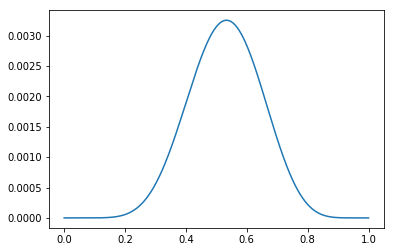

In [105]:
# 3M1
posterior2 = pd.Series(
    data=ralphlib.grid_approx(
        ralphlib.uniform_prior,
        world_toss_likelihood(8, 15),
        grid
    ),
    index=grid
)
posterior2.plot()

In [106]:
# 3M2
sample2 = ralphlib.sample(posterior2, 10000)
hdpi(sample2, 0.9)

(0.34234234234234234, 0.7247247247247247)

(array([   2.,   44.,  113.,  267.,  499.,  852., 1068., 1386., 1444.,
        1468., 1146.,  865.,  515.,  242.,   89.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

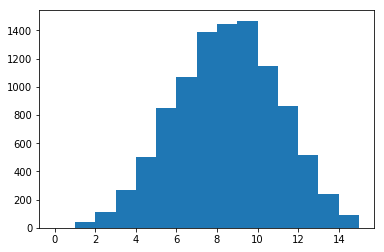

In [107]:
# 3M3
posterior_predictive_samples = np.vectorize(lambda p: np.random.binomial(15, p))(sample2)
plt.hist(posterior_predictive_samples, range(0, 16))

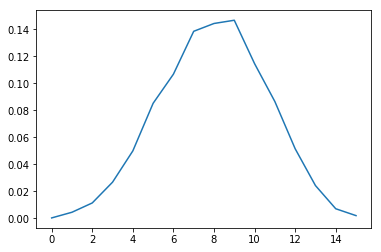

In [108]:
pp_vals, pp_counts = np.unique(posterior_predictive_samples, return_counts=True)
pp_distr = pd.Series(
    data=pp_counts / len(posterior_predictive_samples),
    index=pp_vals
)
pp_distr.plot()

In [109]:
pp_distr[8]

0.1444

In [110]:
# 3M4
posterior_predictive_samples_3m4 = np.vectorize(lambda p: np.random.binomial(9, p))(sample2)
pp_3m4_vals, pp_3m4_counts = np.unique(posterior_predictive_samples_3m4, return_counts=True)
pp_3m4_distr = pd.Series(
    data=(pp_3m4_counts / len(sample2)),
    index=pp_3m4_vals
)
pp_3m4_distr[6]

0.1816

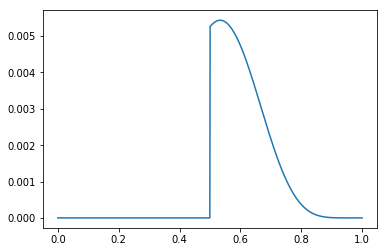

In [138]:
# 3M7
def nonuniform_prior(grid):
    gte0_5_prior = ralphlib.uniform_prior(grid[grid >= 0.5])
    gte0_5_prior *= 2
    lt0_5_prior = grid[grid < 0.5]
    lt0_5_prior.fill(0)
    return pd.Series(
        data=np.concatenate((lt0_5_prior, gte0_5_prior)),
        index=grid
    )

posterior_non_uniform = pd.Series(
    data=ralphlib.grid_approx(
        nonuniform_prior,
        world_toss_likelihood(8, 15),
        grid
    ),
    index=grid
)
posterior_non_uniform.plot()

(array([2.41583e+05, 2.30929e+05, 1.97986e+05, 1.49147e+05, 9.67010e+04,
        5.24000e+04, 2.25590e+04, 7.11000e+03, 1.46700e+03, 1.18000e+02]),
 array([0.5005005 , 0.54464464, 0.58878879, 0.63293293, 0.67707708,
        0.72122122, 0.76536537, 0.80950951, 0.85365365, 0.8977978 ,
        0.94194194]),
 <a list of 10 Patch objects>)

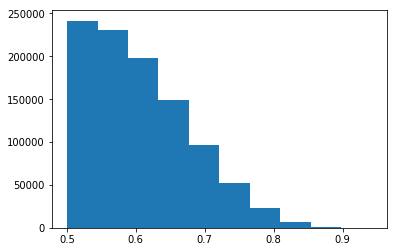

In [168]:
nonuniform_sample = ralphlib.sample(posterior_non_uniform, 1000000)
plt.hist(nonuniform_sample)

In [169]:
hdpi(nonuniform_sample, 0.9)

(0.5005005005005005, 0.7147147147147147)

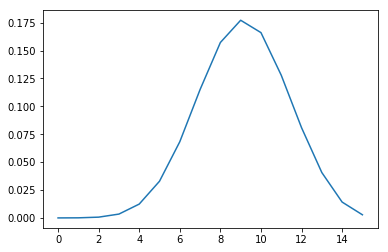

In [170]:
pp_sample = np.vectorize(lambda p: np.random.binomial(15, p))(nonuniform_sample)
pp_vals, pp_counts = np.unique(pp_sample, return_counts=True)
pp_distr = pd.Series(
    data=pp_counts / len(pp_sample),
    index = pp_vals
)
pp_distr.plot()

In [171]:
pp_distr[8]

0.157247

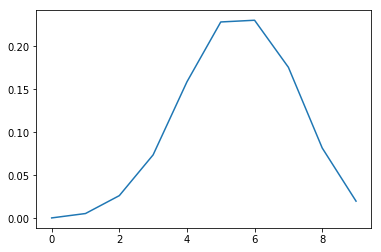

In [165]:
pp_sample9 = np.vectorize(lambda p: np.random.binomial(9, p))(nonuniform_sample)
pp_vals9, pp_counts9 = np.unique(pp_sample9, return_counts=True)
pp_distr9 = pd.Series(
    data=pp_counts9 / len(pp_sample9),
    index = pp_vals9
)
pp_distr9.plot()

In [172]:
pp_distr9[6]

0.2302